In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from functools import lru_cache as memoize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression


In [6]:
data = pd.read_csv('/Users/camillebustalinio/Desktop/Camille/term 2 project/airbnb data/final_data.csv')

In [7]:
#set X,y
comments_SA = data[(data.language=='en')].comments
tags_SA = data[(data.language=='en')].price_tag
#tags_SA_list = ["pos" if tag == 'exp' else 'neg' for tag in tags_SA]
comments_SA.head(), tags_SA.head()

(0    Host was excellent and was contactable / respo...
 1    The place was clean and spacious and the guy t...
 2    This place wasn't as pleasant as we hoped. Had...
 4    Nice room, cool neighbourhood. Note that this ...
 5    The listing was accurate and the location was ...
 Name: comments, dtype: object, 0    neutral
 1        exp
 2        exp
 4        exp
 5        exp
 Name: price_tag, dtype: object)

In [8]:
@memoize(maxsize=128)
def negate_sequence(text):
    from nltk.tokenize import word_tokenize
    negation = False
    delims = "?.,!:;"
    result = []
    words = word_tokenize(text)
    for word in words:
        stripped = word.strip(delims).lower()
        negated = "not_" + stripped if negation else stripped
        result.append(negated)

        if word in ("not", "n't", "no"):
            negation = not negation
        
        if any(c in word for c in delims):
            negation = False

    return result

In [9]:
train_data, test_data, train_target, test_target = train_test_split(comments_SA,tags_SA)

In [10]:
len(train_data), len(test_data)

(121485, 40496)

In [11]:
vectorizer_count = CountVectorizer(tokenizer=negate_sequence,
                                binary=True)
vectorized_count_train_data = vectorizer_count.fit_transform(train_data)

In [12]:
clf = MultinomialNB()
# Call fit method
clf.fit(vectorized_count_train_data, train_target)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [13]:
predict_test = list(clf.predict(vectorizer_count.transform(test_data)))
predict_test[:5]

['neutral', 'neutral', 'neutral', 'neutral', 'neutral']

In [14]:
predict_test[:5], test_target[:5]

(['neutral', 'neutral', 'neutral', 'neutral', 'neutral'], 113683    neutral
 153425    neutral
 109508    neutral
 56243     neutral
 146647      cheap
 Name: price_tag, dtype: object)

In [15]:
vectorized_count_test_data = vectorizer_count.transform(test_data)
clf.score(vectorized_count_test_data, test_target)

0.74217206637692612

In [ ]:
sum(test_target==predict_test)

In [16]:
print("Accuracy:", sum(test_target==predict_test)/len(predict_test))
print("Precision:", precision_score(test_target, predict_test, average="macro") )
print("Recall:", recall_score(test_target, predict_test, average="macro") )
print("F1:", f1_score(test_target, predict_test, average="macro") )


Accuracy: 0.742172066377
Precision: 0.724481689708
Recall: 0.470609534458
F1: 0.49499177932


In [17]:
#weighted metrics, since groups are not balanced
print("Accuracy:", sum(test_target==predict_test)/len(predict_test))
print("Precision:", precision_score(test_target, predict_test, average="weighted") )
print("Recall:", recall_score(test_target, predict_test, average="weighted") )
print("F1:", f1_score(test_target, predict_test, average="weighted") )


Accuracy: 0.742172066377
Precision: 0.732809412067
Recall: 0.742172066377
F1: 0.707269869566


In [18]:
print("Rows: Actual, Columns: Predicted")
print('cheap', 'neutral', 'exp')
confusion_matrix(test_target, predict_test, labels = ['cheap', 'neutral', 'exp'])

Rows: Actual, Columns: Predicted
cheap neutral exp


array([[ 4216,  6356,    11],
       [ 1907, 25644,    55],
       [  160,  1952,   195]])

In [20]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


alpha of max r2 0.1
max r2 0.780919455077


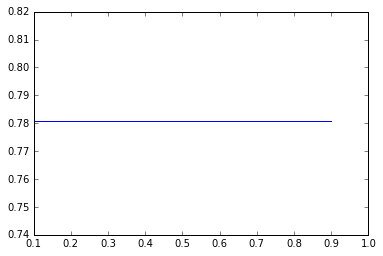

In [21]:
alphas=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
r2=[]
for alpha in alphas:
    clf = MultinomialNB()
    # Call fit method
    clf.fit(vectorized_count_train_data, train_target)
    r2.append(clf.score(vectorized_count_train_data, train_target))

r2 = np.array(r2)
print("alpha of max r2",alphas[np.argmax(r2)])
print("max r2",np.max(r2))
plt.plot(alphas, r2);

In [26]:
logistic_regression = LogisticRegression(C=1.0, solver = 'sag',max_iter=100, multi_class='multinomial', n_jobs=-1)
logistic_regression.fit(vectorized_count_train_data, train_target)
logistic_regression.score(vectorized_count_test_data,test_target)

/Applications/anaconda/lib/python3.5/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.77027360726985383

In [29]:
logistic_regression = LogisticRegression(C=1.0, solver = 'newton-cg',max_iter=100, multi_class='multinomial', n_jobs=-1)
logistic_regression.fit(vectorized_count_train_data, train_target)
logistic_regression.score(vectorized_count_test_data,test_target)

0.76894014223627027

In [40]:
logistic_regression = LogisticRegression(C=1.0, solver = 'lbfgs',max_iter=100, multi_class='multinomial', n_jobs=-1)
logistic_regression.fit(vectorized_count_train_data, train_target)
logistic_regression.score(vectorized_count_test_data,test_target)

0.76451995258790995

of all multinomial solver options, SAG (Stochastic Average Gradient) performed best

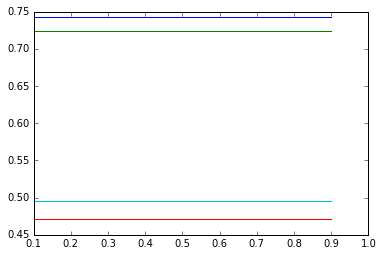

In [36]:
C=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
accuracy=[]
precision=[]
recall = []
F1 = []
n_test = len(test_target)
for c in C:
    logistic_regression = LogisticRegression(C=c, solver = 'sag',max_iter=500, multi_class='multinomial', n_jobs=-1)
    logistic_regression.fit(vectorized_count_train_data, train_target)
    test_predict = logistic_regression.predict(vectorized_count_test_data)
    accuracy.append(sum(test_target==predict_test)/n_test)
    precision.append(precision_score(test_target, predict_test, average="macro") )
    recall.append(recall_score(test_target, predict_test, average="macro") )
    F1.append(f1_score(test_target, predict_test, average="macro") )

plt.plot(C,accuracy);
plt.plot(C,precision);
plt.plot(C,recall);
plt.plot(C,F1);




In [37]:
1+1

2

In [33]:
print("Accuracy:", accuracy[0])
print("Precision:", precision[0])
print("Recall:", recall[0])
print("F1:", F1[0])

Accuracy: 0.742172066377
Precision: 0.724481689708
Recall: 0.470609534458
F1: 0.49499177932


In [38]:
print("Rows: Actual, Columns: Predicted")
print('cheap', 'neutral', 'exp')
confusion_matrix(test_target, test_predict, labels = ['cheap', 'neutral', 'exp'])

Rows: Actual, Columns: Predicted
cheap neutral exp


array([[ 5160,  5360,    63],
       [ 2107, 25196,   303],
       [  162,  1334,   811]])

In [39]:
print("Accuracy:", sum(test_target==test_predict)/len(test_predict))
print("Precision:", precision_score(test_target, test_predict, average="weighted") )
print("Recall:", recall_score(test_target, test_predict, average="weighted") )
print("F1:", f1_score(test_target, test_predict, average="weighted") )

Accuracy: 0.76963156855
Precision: 0.759372680848
Recall: 0.76963156855
F1: 0.753638629695


## Results:

Comment vectors were fitted into Classification models: Multinomial Naive Bayes and Multinomial Logistic Regression. 

In all metrics (accuracy, precision, recall and F1, Logistic Regression(using SAG solver)had better results. Weighted metrics were used for calculations since data is unbalanced.